In [11]:
!pip install faker pandas

In [12]:
!pip install reportlab

In [13]:
!pip install transformers
!pip install torch

In [14]:
!pip install PyPDF2 sentence-transformers scikit-learn pandas

In [15]:
import pandas as pd
from google.colab import files
import os
from reportlab.lib.pagesizes import A4
from datetime import datetime, timedelta
from reportlab.pdfgen import canvas
import os
import hashlib

In [16]:
import random
from faker import Faker
import pandas as pd

fake = Faker()
Faker.seed(42)
random.seed(42)

# Add provinces and formatting rules
provinces = ['Ontario', 'British Columbia', 'Alberta']

def generate_healthcard(province):
    if province == 'Ontario':
        return ''.join([str(random.randint(0, 9)) for _ in range(10)])
    elif province == 'British Columbia':
        return '9' + ''.join([str(random.randint(0, 9)) for _ in range(9)])  # PHN starts with 9
    elif province == 'Alberta':
        return ''.join([str(random.randint(0, 9)) for _ in range(9)])  # ULI is 9 digits

def generate_postal_code(province):
    if province == 'Ontario':
        start = 'M'  # Toronto area
    elif province == 'British Columbia':
        start = 'V'  # Vancouver area
    elif province == 'Alberta':
        start = 'T'  # Calgary area
    return f"{start}{random.randint(1, 9)}{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')} {random.randint(1, 9)}{random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}{random.randint(1, 9)}"

def enforce_test_if_needed(symptoms, dept, current_test):
    high_risk_symptoms = {
        'Ultrasound': ['abdominal pain', 'liver tenderness', 'kidney pain'],
        'Cardiology': ['chest pain', 'palpitations', 'shortness of breath'],
        'Neurology': ['memory loss', 'blurred vision', 'dizziness'],
        'Dermatology': ['skin discoloration'],
        'Psychiatry': ['panic attacks', 'depression'],
        'ENT': ['hearing loss', 'blocked nose', 'tinnitus'],
        'Oncology': ['lump in breast', 'unexplained weight loss', 'bone pain']
    }

    high_risk = high_risk_symptoms.get(dept, [])
    if any(sym in high_risk for sym in symptoms):
        # If current test is missing or inappropriate, assign first available
        valid_tests = department_data[dept]['test_type']
        if current_test == 'Not Applicable' or current_test not in valid_tests:
            return valid_tests[0]
    return current_test

# Urgent test types
urgent_tests = ['CT', 'MRI', 'Biopsy']

departments = ['Cardiology', 'Neurology', 'Dermatology', 'Psychiatry', 'ENT', 'Ultrasound', 'Oncology']

department_data = {
    'Cardiology': {
        'symptoms': ['chest pain', 'shortness of breath', 'palpitations', 'fatigue', 'irregular heartbeat',
                     'mild dizziness', 'occasional palpitations', 'slight swelling'],
        'routine_symptoms': ['mild dizziness', 'occasional palpitations', 'slight swelling'],
        'summary': 'Patient experiences {}. ECG suggests arrhythmia. BP elevated. Possible cardiac issue.',
        'test_type': ['ECG', 'Echocardiogram', 'CT', 'Not Applicable']
    },
    'Neurology': {
        'symptoms': ['headache', 'dizziness', 'numbness in limbs', 'memory loss', 'blurred vision',
                     'occasional headaches', 'mild numbness'],
        'routine_symptoms': ['occasional headaches', 'mild numbness'],
        'summary': 'Reports {}. MRI shows mild abnormalities. Suspected neurological involvement.',
        'test_type': ['MRI', 'CT', 'Not Applicable']
    },
    'Dermatology': {
        'symptoms': ['rash', 'itching', 'skin discoloration', 'dry skin', 'peeling',
                     'mild rash', 'dry skin patches'],
        'routine_symptoms': ['mild rash', 'dry skin patches'],
        'summary': 'Observed {}. Suspect dermatitis or allergy.',
        'test_type': ['Skin Biopsy', 'Not Applicable']
    },
    'Psychiatry': {
        'symptoms': ['anxiety', 'insomnia', 'depression', 'panic attacks', 'mood swings',
                     'stress', 'mild anxiety'],
        'routine_symptoms': ['stress', 'mild anxiety'],
        'summary': 'Exhibits signs of {}. Referred for further psychiatric evaluation.',
        'test_type': ['Not Applicable']
    },
    'ENT': {
        'symptoms': ['hearing loss', 'earache', 'sore throat', 'blocked nose', 'tinnitus',
                     'occasional sore throat', 'mild nasal congestion'],
        'routine_symptoms': ['occasional sore throat', 'mild nasal congestion'],
        'summary': '{} for 2 weeks. ENT exam recommended.',
        'test_type': ['Audiometry', 'X-Ray', 'Not Applicable']
    },
    'Ultrasound': {
        'symptoms': ['abdominal pain', 'pelvic discomfort', 'liver tenderness', 'kidney pain',
                     'mild pelvic discomfort'],
        'routine_symptoms': ['mild pelvic discomfort'],
        'summary': 'Complains of {}. Ultrasound advised for abdominal scan.',
        'test_type': ['Ultrasound']
    },
    'Oncology': {
        'symptoms': ['lump in breast', 'unexplained weight loss', 'persistent fatigue', 'bone pain',
                     'occasional fatigue'],
        'routine_symptoms': ['occasional fatigue'],
        'summary': '{} observed. Biopsy recommended. Possible malignancy.',
        'test_type': ['CT', 'MRI', 'Biopsy']
    }
}

medications_list = [
    'Metformin', 'Lisinopril', 'Atorvastatin', 'Amlodipine', 'Albuterol', 'Levothyroxine',
    'Ibuprofen', 'Omeprazole', 'Hydrochlorothiazide', 'Losartan', 'Amoxicillin', 'Sertraline'
]

allergies_list = [
    'Penicillin', 'Pollen', 'Dust mites', 'Bee stings', 'Peanuts', 'Shellfish',
    'Latex', 'Cats', 'Mold', 'Aspirin'
]

care_plans = [
    'Follow-up in 2 weeks', 'Surgery scheduled', 'Prescribed medication',
    'Advised physiotherapy', 'Mental health counseling', 'Radiation therapy scheduled',
    'Lifestyle modifications advised'
]

occupations = [
    'Software Engineer', 'Construction Worker', 'Teacher', 'Driver', 'Nurse', 'Cashier',
    'Electrician', 'Office Assistant', 'Mechanic', 'Data Analyst', 'Athlete', 'Warehouse Worker',
    'Waiter', 'Student', 'Retired', 'Architect', 'Accountant', 'Social Worker', 'Chef',
    'Musician', 'Police Officer', 'Firefighter', 'Delivery Driver', 'Fitness Trainer', 'Photographer',
    'Journalist', 'Graphic Designer', 'Assembly Line Worker', 'Farmer', 'Lawyer', 'Writer'
]

test_results_choices = ['Pending', 'Completed']
past_treatments = [
    'Appendectomy', 'Knee surgery', 'Heart bypass', 'Gallbladder removal',
    'None', 'Tonsillectomy', 'Back surgery', 'Fracture repair', 'Migraine treatment', 'Chemotherapy'
]

medical_history_list = [
    'Appendectomy', 'Knee surgery', 'Heart bypass', 'Gallbladder removal',
    'Family history of diabetes', 'Family history of heart disease',
    'Family history of cancer', 'Migraine treatment', 'Chemotherapy',
    'No significant history'
]

# Step 1: Add referral reasons per department
referral_reasons = {
    'Cardiology': [
        "Evaluate chest pain and assess cardiac function",
        "Review ECG abnormalities and rule out arrhythmia",
        "Assess shortness of breath for possible heart failure"
    ],
    'Neurology': [
        "Investigate recurring headaches and memory issues",
        "Assess suspected neurological disorder",
        "Referral for dizziness and possible seizure activity"
    ],
    'Dermatology': [
        "Evaluate persistent rash and possible allergic reaction",
        "Assess skin discoloration for dermatological diagnosis",
        "Referral for chronic eczema or dermatitis"
    ],
    'Psychiatry': [
        "Assess depressive symptoms and provide psychiatric care",
        "Referral for mood swings and panic attacks",
        "Evaluate anxiety and sleep disturbances"
    ],
    'ENT': [
        "Evaluate chronic sore throat and ear pain",
        "Investigate hearing loss and blocked nose",
        "Referral for persistent tinnitus"
    ],
    'Ultrasound': [
        "Assess abdominal pain via ultrasound imaging",
        "Investigate pelvic discomfort with ultrasound",
        "Referral for liver tenderness evaluation"
    ],
    'Oncology': [
        "Evaluate abnormal biopsy and rule out malignancy",
        "Referral for unexplained weight loss and fatigue",
        "Assess suspicious lump for cancer screening"
    ]
}

records = []

for _ in range(500):
    dob = fake.date_of_birth(minimum_age=18, maximum_age=90)
    age = (pd.Timestamp.now().year - dob.year)
    dept = random.choice(departments)
    symptoms = random.sample(department_data[dept]['symptoms'], k=random.randint(2, 3))
    summary = department_data[dept]['summary'].format(", ".join(symptoms))
    available_tests = department_data[dept]['test_type']
    test_type = random.choice(available_tests)
    test_type = enforce_test_if_needed(symptoms, dept, test_type)
    test_result = random.choice(test_results_choices) if test_type != 'Not Applicable' else 'Not Needed'
    medications = random.sample(medications_list, k=random.randint(1, 2))
    allergies = random.sample(allergies_list, k=random.randint(0, 2))
    reason_for_referral = random.choice(referral_reasons[dept])
    province = random.choice(provinces)
    postal_code = generate_postal_code(province)
    healthcard_number = generate_healthcard(province)

    record = {
        'Name': fake.name(),
        'DOB': dob.strftime('%Y-%m-%d'),
        'Age': age,
        'Gender': random.choice(['Male', 'Female']),
        'Occupation': random.choice(occupations),
        'Phone Number': "'" + f"+1-{random.randint(100,999):03}-{random.randint(100,999):03}-{random.randint(1000,9999):04}",
        'Address': f"{fake.street_address()}, {fake.city()}, {province}, {postal_code}",
        'HealthCard Number': healthcard_number,
        'Province': province,
        'Postal Code': postal_code,
        'Blood Type': random.choice(['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']),
        'Medical Condition': f'Potential {dept} issue',
        'Symptoms': ", ".join(symptoms),
        'Medications': ", ".join(medications),
        'Allergies': ", ".join(allergies) if allergies else 'None',
        'Medical History': random.choice(medical_history_list),
        'Test Type': test_type,
        'Test Results': test_result,
        'Reason for Referral': reason_for_referral,
        'Care Plan': random.choice(care_plans),
        'Doctor': fake.name(),
        'Clinical Summary': summary,
    }
    # Define keywords that indicate urgent cases
    urgent_keywords = [
      "chest pain", "stroke", "shortness of breath", "loss of consciousness",
      "bleeding", "seizure", "lump in breast", "unexplained weight loss",
      "bone pain", "memory loss", "palpitations", "abdominal pain",
      "blurred vision", "kidney pain", "liver tenderness"
    ]

    # Combine relevant text fields
    combined_text = f"{', '.join(symptoms)} {record['Medical Condition']} {reason_for_referral}".lower()

    # Assign urgency
    urgency = "Urgent" if any(keyword in combined_text for keyword in urgent_keywords) else "Routine"
    record['Urgency'] = urgency


    records.append(record)

df = pd.DataFrame(records)
print(df.columns)
df.head()

Index(['Name', 'DOB', 'Age', 'Gender', 'Occupation', 'Phone Number', 'Address',
       'HealthCard Number', 'Province', 'Postal Code', 'Blood Type',
       'Medical Condition', 'Symptoms', 'Medications', 'Allergies',
       'Medical History', 'Test Type', 'Test Results', 'Reason for Referral',
       'Care Plan', 'Doctor', 'Clinical Summary', 'Urgency'],
      dtype='object')


,Name,DOB,Age,Gender,Occupation,Phone Number,Address,HealthCard Number,Province,Postal Code,...,Medications,Allergies,Medical History,Test Type,Test Results,Reason for Referral,Care Plan,Doctor,Clinical Summary,Urgency
0,Donald Walker,1981-01-31,44,Female,Office Assistant,'+1-559-703-5557,"819 Johnson Course, East William, Alberta, T9C...",133890838,Alberta,T9C 7B1,...,Sertraline,None,Heart bypass,Ultrasound,Pending,Referral for liver tenderness evaluation,Radiation therapy scheduled,Cristian Santos,"Complains of abdominal pain, liver tenderness....",Urgent
1,Kevin Pacheco,1974-03-09,51,Male,Delivery Driver,'+1-171-146-4733,"65423 Garcia Light, West Melanieview, British ...",9816184959,British Columbia,V5Z 1X8,...,Lisinopril,Pollen,Knee surgery,Not Applicable,Not Needed,Referral for mood swings and panic attacks,Lifestyle modifications advised,Monica Herrera,"Exhibits signs of depression, insomnia, stress...",Routine
2,Juan Calderon,2005-06-11,20,Male,Journalist,'+1-423-510-5386,"310 Kendra Common Apt. 164, Reidstad, British ...",9276483503,British Columbia,V2T 3R4,...,Levothyroxine,Bee stings,Gallbladder removal,CT,Completed,Referral for dizziness and possible seizure ac...,Mental health counseling,Henry Santiago,"Reports memory loss, numbness in limbs. MRI sh...",Urgent
3,Andrea Reid,1985-08-21,40,Male,Waiter,'+1-490-710-8668,"76483 Cameron Trail, East Lydiamouth, Alberta,...",287101226,Alberta,T7S 7L4,...,"Atorvastatin, Amlodipine","Mold, Aspirin",Chemotherapy,Ultrasound,Pending,Investigate pelvic discomfort with ultrasound,Lifestyle modifications advised,Austin Gentry,"Complains of pelvic discomfort, kidney pain, m...",Urgent
4,Christy Porter,1975-10-23,50,Male,Musician,'+1-431-600-1319,"42388 Burgess Meadow Suite 532, Daviston, Albe...",489325288,Alberta,T5Q 3Q2,...,"Ibuprofen, Atorvastatin",Penicillin,Family history of heart disease,CT,Pending,Assess shortness of breath for possible heart ...,Lifestyle modifications advised,Brittany Moore,"Patient experiences irregular heartbeat, occas...",Urgent


In [17]:
# Save to CSV
print("Columns right before saving to CSV:", df.columns.tolist())
df.to_csv("synthetic_generated.csv", index=False)
files.download("synthetic_generated.csv")

Columns right before saving to CSV: ['Name', 'DOB', 'Age', 'Gender', 'Occupation', 'Phone Number', 'Address', 'HealthCard Number', 'Province', 'Postal Code', 'Blood Type', 'Medical Condition', 'Symptoms', 'Medications', 'Allergies', 'Medical History', 'Test Type', 'Test Results', 'Reason for Referral', 'Care Plan', 'Doctor', 'Clinical Summary', 'Urgency']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import hashlib
import os
from datetime import datetime
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import simpleSplit
from reportlab.lib import colors

def create_referral_pdf(data, filepath, referral_id, referral_date):
    width, height = A4
    x_margin = 50
    y_start = height - 70
    line_height = 18
    right_column_x = 320
    c = canvas.Canvas(filepath, pagesize=A4)
    c.setStrokeColor(colors.green)

    # Header: Ontario Health Home (left, bigger) and Address (right)
    ontario_health_text = "Ontario Health Home"
    address_text = "1 King St, Toronto, ON, M1N 2P3"
    logo_path = "/content/logo.png"

    # Draw the image: (x, y, width, height)
    c.drawImage(logo_path, x=48, y=800, width=140, height=25)

    # Ontario Health Home - Bigger and on the left
    #c.setFont("Helvetica-Bold", 16)
    #c.drawString(x_margin, height - 40, ontario_health_text)

    # Address - smaller, on the right
    c.setFont("Helvetica", 10)
    address_width = c.stringWidth(address_text, "Helvetica", 10)
    c.drawString(width - 200, height - 40, address_text)

    # Title centered
    c.setFont("Helvetica-Bold", 16)
    title = "Patient Referral Document"
    title_width = c.stringWidth(title, "Helvetica-Bold", 16)

    # Center title *between margins*, not full page width
    title_x = x_margin + (width - 2 * x_margin - title_width) / 2
    c.drawString(title_x, y_start, title)

    y = y_start - 15

    # Horizontal line below title
    c.setStrokeColor(colors.green)
    c.setLineWidth(1)
    #c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Patient Information Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Patient Information")
    y -= 20
    c.setFont("Helvetica", 11)
    c.setFillColor(colors.black)
    c.setStrokeColor(colors.black)

    # Helper function to draw label and value with line, side by side
    def draw_label_and_line(label, value, x_label, x_line, y_pos, line_length=100):
        c.setFont("Helvetica", 11)
        # Draw label + colon
        c.drawString(x_label, y_pos, f"{label}:")
        # Draw value above line, a bit to the right
        c.drawString(x_line, y_pos, str(value))
        # Draw underline below the value
        line_y = y_pos - 3
        c.line(x_line, line_y, x_line + line_length, line_y)

    # Patient Information Header
    c.setFont("Helvetica-Bold", 16)
    title = "Patient Referral Document"
    title_width = c.stringWidth(title, "Helvetica-Bold", 16)
    line_y_top = y_start + 25
    c.setLineWidth(1)
    c.setStrokeColor(colors.green)
    c.line(x_margin, line_y_top, width - x_margin, line_y_top)
    c.setStrokeColor(colors.black)

    # Layout constants
    left_col_x = x_margin
    right_col_x = right_column_x
    line_spacing = 22
    underline_length = 140
    long_underline_length = 150
    label_width_fixed = 85

    # Helper to draw label + aligned underline + value on top
    def draw_label_value_block(label, value, x, y_pos, is_long=False):
      c.setFont("Helvetica", 11)
      c.drawString(x, y_pos, f"{label}:")
      underline_start = x + label_width_fixed
      value_str = str(value)

      # Calculate text width for value string
      text_width = c.stringWidth(value_str, "Helvetica", 11)
      padding = 10  # pixels padding after the value text

      # Adjust underline length: longer for 'is_long' fields like Address
      if is_long:
        line_length = 410 #max(text_width + padding, long_underline_length)
      else:
        line_length = max(text_width + padding, underline_length)

      display_value = value_str

      c.drawString(underline_start, y_pos, display_value)
      c.line(underline_start, y_pos - 3, underline_start + line_length, y_pos - 3)

    # Patient Info fields
    patient_left = [
        ("Referral ID", referral_id),
        ("Referral Date", referral_date),
        ("Name", data["Name"]),
        ("Date of Birth", data.get("DOB", "N/A")),
        ("Phone Number", str(data["Phone Number"]).replace("'", "")),
        ("Address", data["Address"]),
    ]

    patient_right = [
        ("HealthCard", data["HealthCard Number"]),
        ("Blood Type", data["Blood Type"]),
        ("Occupation", data["Occupation"]),
        ("Age", data["Age"]),
        ("Gender", data["Gender"]),
    ]

    # Draw fields aligned
    for i in range(max(len(patient_left), len(patient_right))):
        y_pos = y - i * line_spacing
        if i < len(patient_left):
            label, value = patient_left[i]
            draw_label_value_block(label, value, left_col_x, y_pos, is_long=(label == "Address"))
        if i < len(patient_right):
            label, value = patient_right[i]
            draw_label_value_block(label, value, right_col_x, y_pos)

    y -= (max(len(patient_left), len(patient_right)) * line_spacing) + 20

    # Horizontal line before Medical Information
    c.setLineWidth(1)
    c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Medical Information Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Medical Information")
    y -= 20
    c.setFillColor(colors.black)
    c.setFont("Helvetica", 11)

    medical_fields = [
        ("Medical Condition", data["Medical Condition"]),
        ("Symptoms", data["Symptoms"]),
        ("Medical History", data["Medical History"]),
        ("Medications", data["Medications"]),
        ("Allergies", data["Allergies"]),
        ("Test Type", data.get("Test Type", "Not Applicable")),
        ("Test Results", data["Test Results"]),
        ("Reason for Referral", data.get("Reason for Referral", "Not specified")),
        ("Care Plan", data["Care Plan"]),
        ("Doctor", data["Doctor"]),
    ]

    for label, value in medical_fields:
    # Check if there's enough space for 3 lines (label + some value lines + margin)
      min_lines_needed = 3
      if y < 60 + (min_lines_needed * line_height):
        c.showPage()
        y = height - 50
        c.setFont("Helvetica-Bold", 13)
        c.drawString(x_margin, y, "Medical Information (cont.)")
        y -= 25
        c.setLineWidth(0.5)
        c.line(x_margin, y, width - x_margin, y)
        y -= 30
        c.setFont("Helvetica", 11)

      wrapped_lines = simpleSplit(f"{value}", "Helvetica", 11, width - 2 * x_margin)
      draw_label_and_line(label, wrapped_lines[0], x_margin, x_margin + 150, y,line_length=300)
      y -= line_height
      for line in wrapped_lines[1:]:
        if y < 60:
            c.showPage()
            y = height - 50
            c.setFont("Helvetica", 11)
        c.drawString(x_margin, y, line)
        y -= line_height
      y -= 10


    # Horizontal line before Clinical Summary
    y -= 10
    c.setLineWidth(1)
    c.line(x_margin, y, width - x_margin, y)
    y -= 20

    # Clinical Summary Header
    c.setFont("Helvetica-Bold", 13)
    c.setFillColor(colors.green)
    c.drawString(x_margin, y, "Clinical Summary")
    y -= 20
    c.setFont("Helvetica", 11)
    c.setFillColor(colors.black)

    summary_lines = simpleSplit(data["Clinical Summary"], "Helvetica", 11, width - 2 * x_margin)
    for line in summary_lines:
        c.drawString(x_margin, y, line)
        y -= line_height
        if y < 60:
            c.showPage()
            y = height - 50
            c.setFont("Helvetica", 11)

    c.save()


# --- Main code example to generate files ---
import pandas as pd

df = pd.read_csv("synthetic_generated.csv")

output_folder = "referrals_forms"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

for idx, row in df.head(500).iterrows():
    # Create a unique referral id
    data_str = f"{row['Name']}_{row.get('DOB', 'N/A')}_{datetime.now().isoformat()}"
    referral_id = "REF-" + hashlib.md5(data_str.encode()).hexdigest()[:8]
    referral_date = datetime.today().strftime("%Y-%m-%d")

    full_name = row.get("Name", "").strip()
    if " " in full_name:
      first_name, _ = full_name.split(" ", 1)
    else:
      first_name = full_name

    first_part = first_name[:4].lower() if first_name else "anon"

    healthcard = str(row.get("HealthCard Number", "0000")).strip()
    last_part = healthcard[-4:] if healthcard.isdigit() or healthcard[-4:].isdigit() else "0000"

    filename = f"referral_{first_part}_{last_part}.pdf"

    # Save directory and full path
    save_dir = "./referrals_forms"
    os.makedirs(save_dir, exist_ok=True)
    filepath = os.path.join(save_dir, filename)
    #filepath = os.path.join(output_folder, filename)
    create_referral_pdf(row, filepath, referral_id, referral_date)

print(f"Generated {min(len(df), 500)} referral PDFs in '{output_folder}'")

Generated 500 referral PDFs in 'referrals_forms'


In [19]:
import os

# Folder where PDFs are saved
output_folder = "referrals_forms"

# List PDF files
pdf_files = sorted(os.listdir(output_folder))

# Get the first one
first_pdf_path = os.path.join(output_folder, pdf_files[10])
print(first_pdf_path)

from google.colab import files

files.download(first_pdf_path)

referrals_forms/referral_alys_5290.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2


In [21]:
import transformers
print(transformers.__version__)


4.52.3


In [22]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [23]:
# This gives the RAM session overflow error in Google Colab because the entire dataset is tokenized and loaded into memory at once.

"""
import os
from PyPDF2 import PdfReader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, Features, ClassLabel, Value

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    full_text = ""
    for page in reader.pages:
        text = page.extract_text()
        if text:
            full_text += text + " "
    return full_text.strip()

def determine_urgency(text):

    urgent_keywords = [
        "chest pain", "stroke", "shortness of breath", "loss of consciousness",
        "bleeding", "seizure", "lump in breast", "unexplained weight loss",
        "bone pain", "memory loss", "palpitations", "abdominal pain"
    ]
    return 1 if any(keyword in text.lower() for keyword in urgent_keywords) else 0

# Load all PDFs and extract text + labels
pdf_dir = "./referrals_forms"
texts = []
labels = []

for fname in os.listdir(pdf_dir):
    if fname.endswith(".pdf"):
        text = extract_text_from_pdf(os.path.join(pdf_dir, fname))
        if not text.strip():
            continue  # Skip empty PDFs

        urgency = determine_urgency(text)
        texts.append(text)
        labels.append(urgency)

# Create dataset
features = Features({
    "text": Value("string"),
    "labels": ClassLabel(num_classes=2, names=["routine", "urgent"])
})

dataset = Dataset.from_dict({"text": texts, "labels": labels}, features=features)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize dataset
dataset = dataset.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"],
    load_from_cache_file=False
)

# Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training args (compatible with older transformers)
training_args = TrainingArguments(
    output_dir="./bert_urgency_results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Train
trainer.train()
"""

'\nimport os\nfrom PyPDF2 import PdfReader\nfrom transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments\nfrom datasets import Dataset, Features, ClassLabel, Value\n\ndef extract_text_from_pdf(pdf_path):\n    reader = PdfReader(pdf_path)\n    full_text = ""\n    for page in reader.pages:\n        text = page.extract_text()\n        if text:\n            full_text += text + " "\n    return full_text.strip()\n\ndef determine_urgency(text):\n\n    urgent_keywords = [\n        "chest pain", "stroke", "shortness of breath", "loss of consciousness",\n        "bleeding", "seizure", "lump in breast", "unexplained weight loss",\n        "bone pain", "memory loss", "palpitations", "abdominal pain"\n    ]\n    return 1 if any(keyword in text.lower() for keyword in urgent_keywords) else 0\n\n# Load all PDFs and extract text + labels\npdf_dir = "./referrals_forms"\ntexts = []\nlabels = []\n\nfor fname in os.listdir(pdf_dir):\n    if fname.endswith(".pdf"):\n    

Train: 400 | Val: 50 | External holdout: 50


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Step,Training Loss
10,0.749300
20,0.720000
30,0.688900
40,0.670700
50,0.722200
60,0.649000
70,0.443300
80,0.215300
90,0.435000
100,0.242800



Evaluation on validation set...



Validation Classification Report:
              precision    recall  f1-score   support

     routine     0.9630    1.0000    0.9811        26
      urgent     1.0000    0.9583    0.9787        24

    accuracy                         0.9800        50
   macro avg     0.9815    0.9792    0.9799        50
weighted avg     0.9807    0.9800    0.9800        50


Validation Confusion Matrix:
                Predicted Routine  Predicted Urgent
Actual Routine                 26                 0
Actual Urgent                   1                23

Evaluation on external holdout set (never seen during training)...



Holdout Classification Report:
              precision    recall  f1-score   support

     routine     0.9412    1.0000    0.9697        16
      urgent     1.0000    0.9706    0.9851        34

    accuracy                         0.9800        50
   macro avg     0.9706    0.9853    0.9774        50
weighted avg     0.9812    0.9800    0.9802        50


Holdout Confusion Matrix:
                Predicted Routine  Predicted Urgent
Actual Routine                 16                 0
Actual Urgent                   1                33


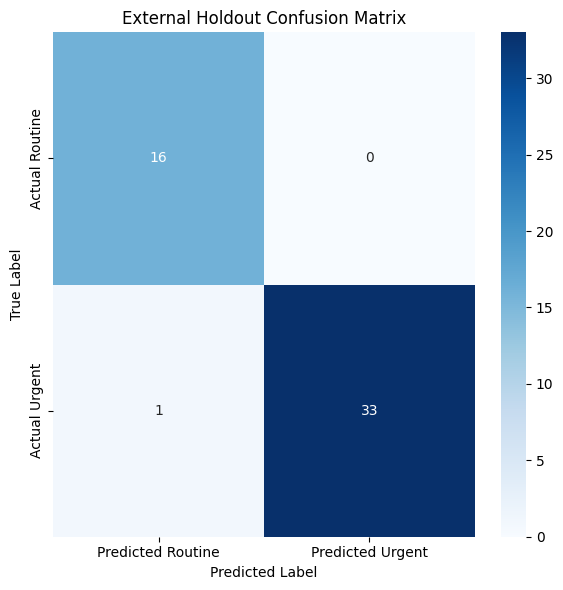


Training and evaluation completed successfully.


In [26]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import shuffle
from transformers import Trainer, TrainingArguments
from datasets import Dataset, Features, ClassLabel, Value

# Disable external tracking
os.environ["WANDB_DISABLED"] = "true"
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "true"
os.environ["DISABLE_TENSORBOARD"] = "true"

# 1. Shuffle and split the dataset properly

# Shuffle before creating dataset
texts, labels = shuffle(texts, labels, random_state=42)

# Create HuggingFace dataset with schema
features = Features({
    "text": Value("string"),
    "labels": ClassLabel(num_classes=2, names=["routine", "urgent"])
})
dataset = Dataset.from_dict({"text": texts, "labels": labels}, features=features)

# Hold out 10 samples for true external validation
split = dataset.train_test_split(test_size=0.2, seed=42)
split2 = split["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = split["train"]
val_dataset = split2["train"]  # for Trainer's eval_dataset
external_holdout = split2["test"]  # for final evaluation

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | External holdout: {len(external_holdout)}")

# 2. Tokenization

from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
val_dataset = val_dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
external_holdout = external_holdout.map(tokenize_fn, batched=True, remove_columns=["text"])

# 3. Load model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
torch.cuda.empty_cache()

# 4. Training setup

training_args = TrainingArguments(
    output_dir="./distilbert_results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # Slightly reduced to avoid overfitting
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    disable_tqdm=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 5. Training
print("Starting training...")
trainer.train()

# 6. Evaluation on internal val set
print("\nEvaluation on validation set...")
val_pred = trainer.predict(val_dataset)
val_labels = val_dataset["labels"]
val_preds = np.argmax(val_pred.predictions, axis=1)

print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["routine", "urgent"], digits=4))

print("\nValidation Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(val_labels, val_preds),
                   index=["Actual Routine", "Actual Urgent"],
                   columns=["Predicted Routine", "Predicted Urgent"]))

# 7. Evaluation on true holdout set
print("\nEvaluation on external holdout set (never seen during training)...")
holdout_pred = trainer.predict(external_holdout)
holdout_labels = external_holdout["labels"]
holdout_preds = np.argmax(holdout_pred.predictions, axis=1)

print("\nHoldout Classification Report:")
print(classification_report(holdout_labels, holdout_preds, target_names=["routine", "urgent"], digits=4))

print("\nHoldout Confusion Matrix:")
cm = confusion_matrix(holdout_labels, holdout_preds)
print(pd.DataFrame(cm,
                   index=["Actual Routine", "Actual Urgent"],
                   columns=["Predicted Routine", "Predicted Urgent"]))

# 8. Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted Routine", "Predicted Urgent"],
            yticklabels=["Actual Routine", "Actual Urgent"])
plt.title("External Holdout Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 9. Cleanup
del trainer
torch.cuda.empty_cache()
print("\nTraining and evaluation completed successfully.")


In [27]:
from collections import Counter

# 0 = routine, 1 = urgent
label_counts = Counter(labels)
print(f"Routine: {label_counts[0]}")
print(f"Urgent: {label_counts[1]}")


Routine: 245
Urgent: 255


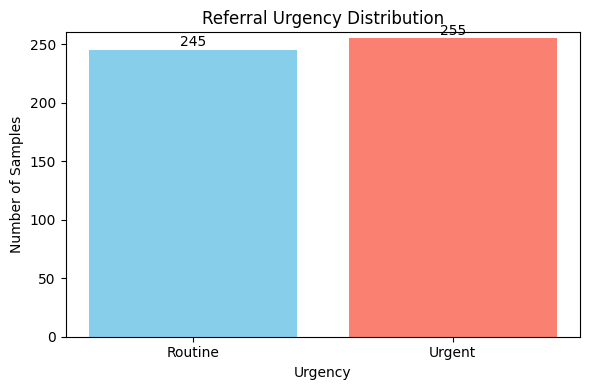

In [28]:
import matplotlib.pyplot as plt

def plot_class_distribution(labels):
    classes = ['Routine', 'Urgent']
    counts = [labels.count(0), labels.count(1)]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(classes, counts, color=['skyblue', 'salmon'])
    plt.title('Referral Urgency Distribution')
    plt.xlabel('Urgency')
    plt.ylabel('Number of Samples')
    plt.ylim(0, max(counts) + 5)

    # Annotate counts on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_class_distribution(labels)
